<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/twyncoder/dl-handson-tcb/blob/master/L03b_IntroCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Redes de Aprendizaje Profundo básicas con Keras y Tensorflow.
## *Convolutional Deep Neural Networks (CNN) para clasificación multi-clase*

# 0. Preparación del entorno y comprobación de requisitos

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Información de versiones

In [2]:
print(tf.__version__)

1.15.8


### Comprobar si disponemos de una GPU

In [3]:
print(tf.test.gpu_device_name())
#devices = tf.config.experimental.list_physical_devices()
#for device in devices:    
#    print(device) 

2023-11-30 11:26:37.585378: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-11-30 11:26:37.600062: I tensorflow/stream_executor/platform/default/dso_loader.cc:97] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-11-30 11:26:37.600193: I tensorflow/stream_executor/platform/default/dso_loader.cc:97] Successfully opened dynamic library libdxcore.so
2023-11-30 11:26:37.615560: I tensorflow/stream_executor/platform/default/dso_loader.cc:97] Successfully opened dynamic library libd3d12.so


/device:DML:0


2023-11-30 11:26:38.190001: I tensorflow/core/common_runtime/dml/dml_device_cache.cc:250] DirectML device enumeration: found 2 compatible adapters.
2023-11-30 11:26:38.190126: I tensorflow/core/common_runtime/dml/dml_device_cache.cc:186] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU)
2023-11-30 11:26:38.360707: I tensorflow/core/common_runtime/dml/dml_device_cache.cc:186] DirectML: creating device on adapter 1 (Intel(R) Iris(R) Xe Graphics)


# 1. Dataset

In [14]:
from sklearn.model_selection import train_test_split
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,y_train_full,
                                                     train_size=55000,shuffle=True)

**¡AHORA TÚ!**
- Averigua las dimensiones de los datos de entrada proporcionados en el dataset

In [15]:
#SOLUTION
print(X_train.shape)

(55000, 28, 28)


### Estandarización de las entradas

In [16]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

**¡AHORA TÚ!**
- Observa las dimensiones de `X_mean` y `X_std` con `.shape` y explica cómo se está haciendo la estandarización de los datos de entrada a la red.
- Observa que `X_mean` y `X_std` se calculan sobre el set de entrenamiento, pero después se aplican también para **pseudo estandarizar** el set de validación y el set de test, ¿puedes explicar por qué no se calculan `X_mean` y `X_std` sobre todas las imágenes dispoinbles?.

In [17]:
#SOLUTION
print(X_train.shape)
print(X_mean.shape)
print(X_std.shape)

(55000, 28, 28)
(1, 28, 28)
(1, 28, 28)


In [18]:
# SOLUTION
# X_mean es una imagen de 28x28 px con el valor medio de cada píxel a lo largo de todo el set de entrenamiento
# X_std es una imagen de 28x28 px con la desviación estándar de cada a lo largo de todo el set de entrenamiento
# Cuando vayamos a hacer inferencia con el set de validación y de test, tenemos que aplicar la misma estandarización
# para que las entradas tengan una distribución próxima a la del entrenamiento.

### Ampliación de las dimensiones de entrada
- La red neuronal necesitará que los tensores `X` que representan la entrada tengan 4 dimensiones: <code>(num_imgs,height,width,num_channels)</code>
- Averigua las dimensiones de los datos de entrada proporcionados en el dataset y comprueba si necesitamos añadir la dimensión `nchannels` en base a lo anterior
- Comprueba como quedan las dimensiones de los arrays n-dimensionales de _numpy_ con las muestras (entrenamiento, validación y test) después de ejecutar la siguiente celda.

In [19]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [20]:
#SOLUTION
print(X_train.shape)

(55000, 28, 28, 1)


# 2. Entrenamiento

## Modelo 'base' de red neuronal

In [21]:
model1 = keras.models.Sequential()
model1.add(keras.layers.Conv2D(16, kernel_size=(3, 3),
                 activation='relu', padding='same',
                 input_shape=(28, 28, 1)))
model1.add(keras.layers.MaxPooling2D((2, 2)))
model1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), 
                 activation='relu',  padding='same'))
model1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(32, activation='relu'))
model1.add(keras.layers.Dense(10, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


**¡AHORA TÚ!**
- En base a la anterior definición de red neuronal:
  - Busca información sobre `keras.layers.Conv2D()` y averigua qué quiere decir `padding='same'`. ¿Qué otra opción existe para este parámetro y qué implicaciones tiene usarla? 
  - ¿Cuántos _feature maps_ o `channels` se generan a la salida de la primera capa? ¿de qué tamaño son los _campos receptivos_ o `kernels` de convolución? ¿Y en el caso la segunda capa?

**¡AHORA TÚ!**
- Obtén un `summary()` de la red anterior y contesta a las siguientes cuestiones:
   - Asegúrate de entender cómo disminuye el tamaño de las capas en `height` y `width` desde 28x28 px a la entrada hasta 7x7 después de la última capa de _pooling_.
   - ¿Cuántos parámetros entrenables tiene la red? Compara esta cifra con el número de parámetros de los modelos _fully connected_ de cuadernos anteriores.
   - Puedes probar a cambiar la configuración de `model1` y ver cómo afecta a los tamaños y número de capas.

In [22]:
# SOLUTION
model1.summary()
#keras.utils.plot_model(model, show_shapes=True)
# - La opción padding='same' hace que la salida tenga las mismas dimensiones, debido a que se hace padding antes de hacer la
# convolución. La opción padding='valid' aplica la convolución solamente en la región válida, así que la salida se reducirá
# de acuerdo a las dimensiones del kernel de convolución.
# - En la primera capa hay 16 _feature_maps_ y los kernels de convolución tienen tamaño 3x3
# En la segunda capa...
# La red tiene 55,338 parámetros entrenables, frente a 266,610 que tenía el modelo base anterior


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                50208     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

**¡AHORA TÚ!**
- Entrena la red neuronal durante 15 epochs con un optimizador `adam`
- Ve observando durante el entrenamiento los resultados de `acc` y `val_acc` y compáralos con los obtenidos en cuadernos anteriores.
- Crea una **función** que te permita mostrar en una gráfica la evolución del entrenamiento y que reciba `history` como argumento. Grafica los resultados del entrenamiento con dicha función.
  - ¿Se produce _overfitting_ durante el entrenamiento? 
  - ¿A partir de qué _epoch_ aproximadamente?


In [23]:
# SOLUTION
# En comparación con XX, donde teníamos más parámetros y entrenábamos durante 35 epochs 
# para accuracy de 92% y val_accuracy de 88%
# ... aquí en 15 epochs conseguimos accuracy de 97% y val_accuracy de 90%
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
history1 = model1.fit(X_train, y_train, epochs=15,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 8s 137us/sample - loss: 0.4347 - acc: 0.8473 - val_loss: 0.3090 - val_acc: 0.8914
Epoch 2/15
55000/55000 [==============================] - 5s 89us/sample - loss: 0.2951 - acc: 0.8941 - val_loss: 0.2691 - val_acc: 0.9044
Epoch 3/15
55000/55000 [==============================] - 5s 82us/sample - loss: 0.2516 - acc: 0.9078 - val_loss: 0.2823 - val_acc: 0.8972
Epoch 4/15
55000/55000 [==============================] - 4s 81us/sample - loss: 0.2216 - acc: 0.9182 - val_loss: 0.2740 - val_acc: 0.9044
Epoch 5/15
55000/55000 [==============================] - 4s 80us/sample - loss: 0.2001 - acc: 0.9269 - val_loss: 0.2505 - val_acc: 0.9070
Epoch 6/15
55000/55000 [==============================] - 4s 80us/sample - loss: 0.1806 - acc: 0.9330 - val_loss: 0.2467 - val_acc: 0.9128
Epoch 7/15
55000/55000 [==============================] - 4s 81us/sample - loss: 0.1657 - acc: 0.9388 - val_loss: 0.

In [24]:
# SOLUTION
import pandas as pd
def graph_training(history,name):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)  #--> NECESARIO COMENTAR LA LIMITACIÓN EN EL EJE Y PARA QUE SE VEA EL LOSS
    plt.show()

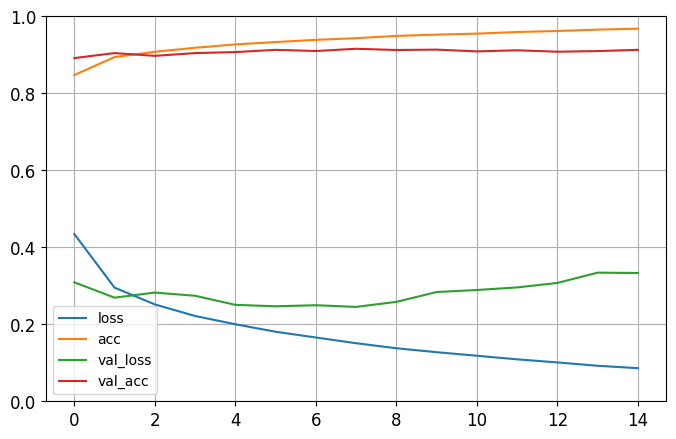

In [25]:
# SOLUTION
graph_training(history1,"model1")

### Salvar modelos
- Puedes salvar los modelos para utilizarlos más adelante, utilizando el siguiente comando:

In [26]:
model1.save("modelo1.h5")

## Batch Normalization 

Vamos a incorporar capas de `BatchNormalization()` a nuestro modelo, igual que en la práctica anterior.
- Llámalo esta vez `model2`
- Batch Normalization actúa como técnica de regularización. 
- Prueba a introducirlo entre las capas de convolución y _pooling_ y en la penúltima capa _fully connected_
- **No** debes incluir las activaciones en la capa anterior a `BatchNormalization()` y **pero debes** incluir una capa de activación en la capa siguiente.
- ¿Cuántos parámetros entrenables y no entrenables se han añadido a la red?
- **No entrenes la red todavía**

In [33]:
# SOLUTION
model2 = keras.models.Sequential()
model2.add(keras.layers.Conv2D(16, kernel_size=(3, 3),
                 padding='same',use_bias=False,
                 input_shape=(28, 28, 1)))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation("relu"))
model2.add(keras.layers.MaxPooling2D((2, 2)))
model2.add(keras.layers.Conv2D(32, kernel_size=(3, 3), 
                 padding='same',use_bias=False))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation("relu"))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(32,use_bias=False))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation("relu"))
model2.add(keras.layers.Dense(10, activation='softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        4608      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 32)       

## Early Stopping

- Parar el entrenamiento es una forma de prevenir que la red sobreentrene y también de no gastar tiempo de cómputo innecesariamente.
- Se puede dejar a la red que siga entrenando durante un tiempo, pero utilizar después en la etapa de inferencia los parámetros que proporcionaron el menor `val_loss` o la mejor `val_acc` (distintos de los de la última _epoch_).

In [34]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,verbose=1)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model2.h5", save_best_only=True)

**¡AHORA TÚ!**
- Vamos a entrenar la red `model2` durante 15 _epochs_ y a guardar los resultados del entrenamiento en una variable `history2`
- Para el entrenamiento, incluye los _callbacks_ `early_stopping_cb` y `model_checkpoint_cb` tal y como los hemos definido arriba. Para ejecutar varios _callback_ simultáneamente recuerda que puedes hacer una lista con corchetes en la llamada en la función `fit()`.
- Mientras se realiza el entrenamiento revisa información sobre `EarlyStopping()` y `ModelCheckpoint()`.
   - https://keras.io/api/callbacks/early_stopping/
   - https://keras.io/api/callbacks/model_checkpoint/
- Finalizado el entrenamiento, representa un gráfico con la evolución de la red y a continuación, responde a las siguientes preguntas:
  - ¿En qué _epoch_ se ha parado el entrenamiento?
  - ¿En qué _epoch_ se obtenía el menor _val_loss_?
  - ¿Los parámetros de qué epoch se han salvado en 'model2.h5'?


In [35]:
# SOLUTION
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
              metrics=["accuracy"])
history2 = model2.fit(X_train, y_train, epochs=15,
                    validation_data=(X_valid, y_valid),callbacks=[early_stopping_cb,model_checkpoint_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 10s 173us/sample - loss: 0.4039 - acc: 0.8671 - val_loss: 0.2998 - val_acc: 0.8900
Epoch 2/15
55000/55000 [==============================] - 9s 156us/sample - loss: 0.2667 - acc: 0.9037 - val_loss: 0.2579 - val_acc: 0.9034
Epoch 3/15
55000/55000 [==============================] - 9s 157us/sample - loss: 0.2285 - acc: 0.9172 - val_loss: 0.2445 - val_acc: 0.9144
Epoch 4/15
55000/55000 [==============================] - 9s 161us/sample - loss: 0.2069 - acc: 0.9243 - val_loss: 0.2416 - val_acc: 0.9106
Epoch 5/15
55000/55000 [==============================] - 9s 159us/sample - loss: 0.1865 - acc: 0.9309 - val_loss: 0.2205 - val_acc: 0.9190
Epoch 6/15
55000/55000 [==============================] - 9s 159us/sample - loss: 0.1699 - acc: 0.9372 - val_loss: 0.2401 - val_acc: 0.9128
Epoch 7/15
55000/55000 [==============================] - 9s 155us/sample - loss: 0.1542 - acc: 0.9437 - val_l

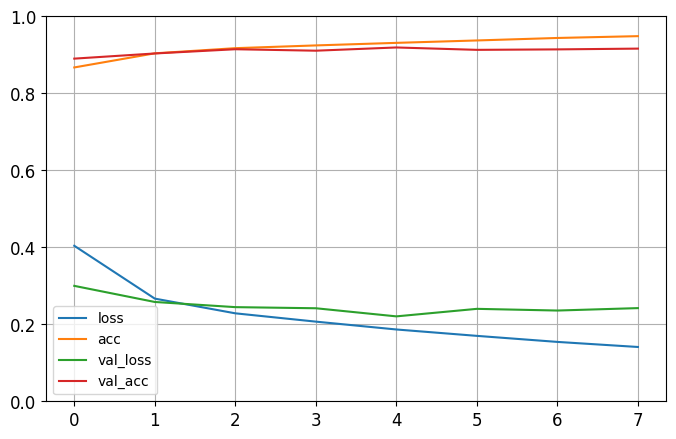

In [36]:
# SOLUTION
graph_training(history2,"model2")

## Variación dinámica del learning rate
- Una forma de prevenir el sobreentrenamiento es ir disminuyendo de manera dinámica el _learning rate_. De hecho, algunos optimizadores lo hacen internamente de manera automática.
- Entre las estrategias más utilizadas encontramos _Reduce on plateau_, que consiste en añadir un _callback_ para que se reduzca el `learning_rate` cuando el _loss_ se queda en una meseta. 

In [69]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.4, patience=2,verbose=1)

**¡AHORA TÚ!**
- Vamos a volver a entrenar modelo `model1` (sin _Batch Normalization_) o `model2`, pero esta vez variando el _learning rate_ dinámicamente. 
- Vuelve a definir el modelo y llámalo `model3`

In [70]:
# SOLUTION

model3 = keras.models.Sequential()
model3.add(keras.layers.Conv2D(16, kernel_size=(3, 3),
                 padding='same',use_bias=False,
                 input_shape=(28, 28, 1)))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Activation("relu"))
model3.add(keras.layers.MaxPooling2D((2, 2)))
model3.add(keras.layers.Conv2D(32, kernel_size=(3, 3), 
                padding='same',use_bias=False))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Activation("relu"))
model3.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(32,use_bias=False))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Activation("relu"))
model3.add(keras.layers.Dense(10, activation='softmax'))
model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
activation_15 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 32)        4608      
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
activation_16 (Activation)   (None, 14, 14, 32)      

In [56]:
# SOLUTION #model1
#model3 = keras.models.Sequential()
#model3.add(keras.layers.Conv2D(16, kernel_size=(3, 3),
#                 activation='relu', padding='same',
#                 input_shape=(28, 28, 1)))
#model3.add(keras.layers.MaxPooling2D((2, 2)))
#model3.add(keras.layers.Conv2D(32, kernel_size=(3, 3), 
#                 activation='relu',  padding='same'))
#model3.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model3.add(keras.layers.Flatten())
#model3.add(keras.layers.Dense(32, activation='relu'))
#model3.add(keras.layers.Dense(10, activation='softmax'))

**¡AHORA TÚ!**
- Añade el _callback_ `lr_scheduler` durante el entrenamiento, junto con los callbacks anteriores: `early_stopping_cb` y `model_checkpoint_cb`.
- Para no sobreescribir `model2.h5` será mejor que vuelvas a definir `model_checkpoint_cb` e incluir esta vez `model3.h5`.
- Lanza un entrenamiento con al menos 20 epochs y empleando el siguiente optimizador
- Mientras se realiza revisa información sobre `EarlyStopping()`.
   - https://keras.io/api/callbacks/reduce_lr_on_plateau/
- Grafica los resultados y compara con entrenamientos anteriores

In [71]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [72]:
#SOLUTION
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model3.h5", save_best_only=True)

In [73]:
# SOLUTION
model3.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history3 = model3.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                   callbacks=[lr_scheduler,early_stopping_cb,model_checkpoint_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 10s 185us/sample - loss: 0.4080 - acc: 0.8614 - val_loss: 0.2964 - val_acc: 0.8916
Epoch 2/20
55000/55000 [==============================] - 10s 173us/sample - loss: 0.2653 - acc: 0.9039 - val_loss: 0.2550 - val_acc: 0.9108
Epoch 3/20
55000/55000 [==============================] - 11s 207us/sample - loss: 0.2272 - acc: 0.9184 - val_loss: 0.2436 - val_acc: 0.9108
Epoch 4/20
55000/55000 [==============================] - 11s 202us/sample - loss: 0.2065 - acc: 0.9235 - val_loss: 0.2440 - val_acc: 0.9114
Epoch 5/20
55000/55000 [==============================] - 11s 199us/sample - loss: 0.1865 - acc: 0.9308 - val_loss: 0.2419 - val_acc: 0.9140
Epoch 6/20
55000/55000 [==============================] - 11s 197us/sample - loss: 0.1735 - acc: 0.9361 - val_loss: 0.2477 - val_acc: 0.9128
Epoch 7/20
54816/55000 [============================>.] - ETA: 0s - loss: 0.1567 - acc: 0.9428
Epoch 0000

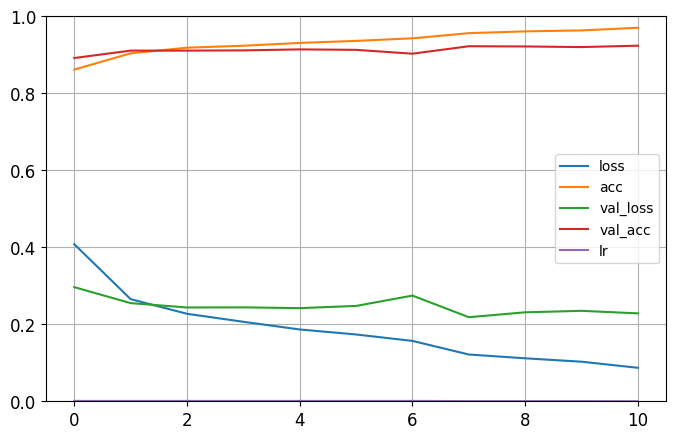

In [74]:
#SOLUCION
graph_training(history3,"model3")

## Dropout
- Puedes introducir capas de Dropout de la siguiente manera.

`keras.layers.Dropout(rate=...)`

**¡AHORA TÚ!**
- Crea un nuevo modelo `model4` añadiendo capas de dropout  después de las capas de _pooling_ en `model2`. Puedes probar con valores de `rate=0.25` por ejemplo.
- Lanza un entrenamiento de al menos 20 _epochs_ y con _Early Stopping_ y que guarde los pesos en `model4.h5`.
- Durante el mismo busca información sobre las capas `Dropout` y el parámetro `rate`.
- Grafica nuevamente los resultados y compara el entrenamiento con los modelos anteriores
- Por último, si el entrenamiento no se hubiera parado en la última _epoch_, salva los resultados con `model4.save("model4.h5")`

In [75]:
# SOLUTION
model4 = keras.models.Sequential()
model4.add(keras.layers.Conv2D(16, kernel_size=(3, 3),
                 padding='same',use_bias=False,input_shape=(28, 28, 1)))
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.Activation('relu'))
model4.add(keras.layers.MaxPooling2D((2, 2)))
model4.add(keras.layers.Dropout(0.25)),
model4.add(keras.layers.Conv2D(32, kernel_size=(3, 3),padding='same',use_bias=False))
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.Activation("relu"))
model4.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(keras.layers.Dropout(0.25)),
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(32,use_bias=False))
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.Activation("relu"))
model4.add(keras.layers.Dense(10, activation='softmax'))
model4.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
activation_18 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 32)        4608      
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 32)      

In [76]:
# SOLUTION
model4.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history4 = model4.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                   callbacks=[lr_scheduler,early_stopping_cb,model_checkpoint_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 14s 251us/sample - loss: 0.5126 - acc: 0.8236 - val_loss: 0.3598 - val_acc: 0.8700
Epoch 2/20
55000/55000 [==============================] - 13s 235us/sample - loss: 0.3553 - acc: 0.8703 - val_loss: 0.2902 - val_acc: 0.8968
Epoch 3/20
55000/55000 [==============================] - 13s 232us/sample - loss: 0.3214 - acc: 0.8825 - val_loss: 0.2648 - val_acc: 0.9010
Epoch 4/20
55000/55000 [==============================] - 13s 233us/sample - loss: 0.3044 - acc: 0.8892 - val_loss: 0.2562 - val_acc: 0.9074
Epoch 5/20
55000/55000 [==============================] - 13s 232us/sample - loss: 0.2864 - acc: 0.8948 - val_loss: 0.2576 - val_acc: 0.9058
Epoch 6/20
55000/55000 [==============================] - 13s 237us/sample - loss: 0.2776 - acc: 0.8966 - val_loss: 0.2459 - val_acc: 0.9078
Epoch 7/20
55000/55000 [==============================] - 13s 242us/sample - loss: 0.2710 - acc: 0.8997 -

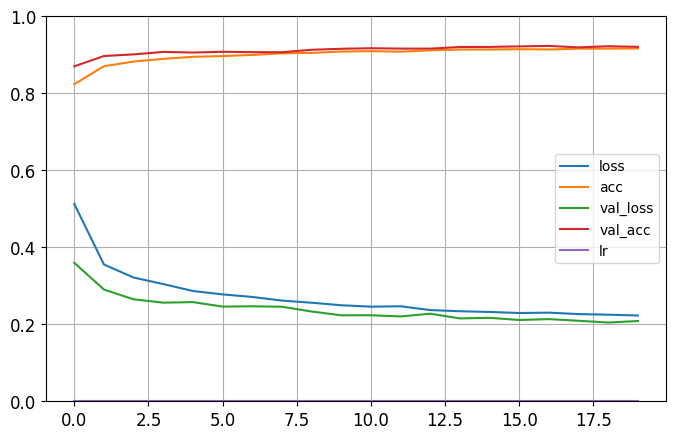

In [77]:
# SOLUTION
graph_training(history4,"model4")

In [78]:
model4.save("model4.h5")

## 3. Test
**¡AHORA TÚ!**
- Carga alguno de los modelos salvados anteriormente y evalúalo (usando `evaluate()`), sobre las muestras reservadas para test. 
- A continuación:
  - Evalúa el modelo sobre el set de test empleando `evaluate()`
  - En otra celda genera predicciones con `predict()` sobre **todo el subconjunto de test**.

In [79]:
#model = keras.models.load_model("model1.h5")
#model = keras.models.load_model("model2.h5")
#model = keras.models.load_model("model3.h5")
model = keras.models.load_model("model4.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [80]:
# SOLUTION
score = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 187us/sample - loss: 0.2264 - acc: 0.9159


In [81]:
# SOLUTION
y_pred = model.predict(X_test)
y_pred = np.argmax(model.predict(X_test),axis=-1)

### Matriz de confusión
**¡AHORA TÚ!**
- Utiliza las predicciones anteriores para generar un matriz de confusión normalizada y otra sin normalizar.
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [83]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [84]:
y_true = y_test

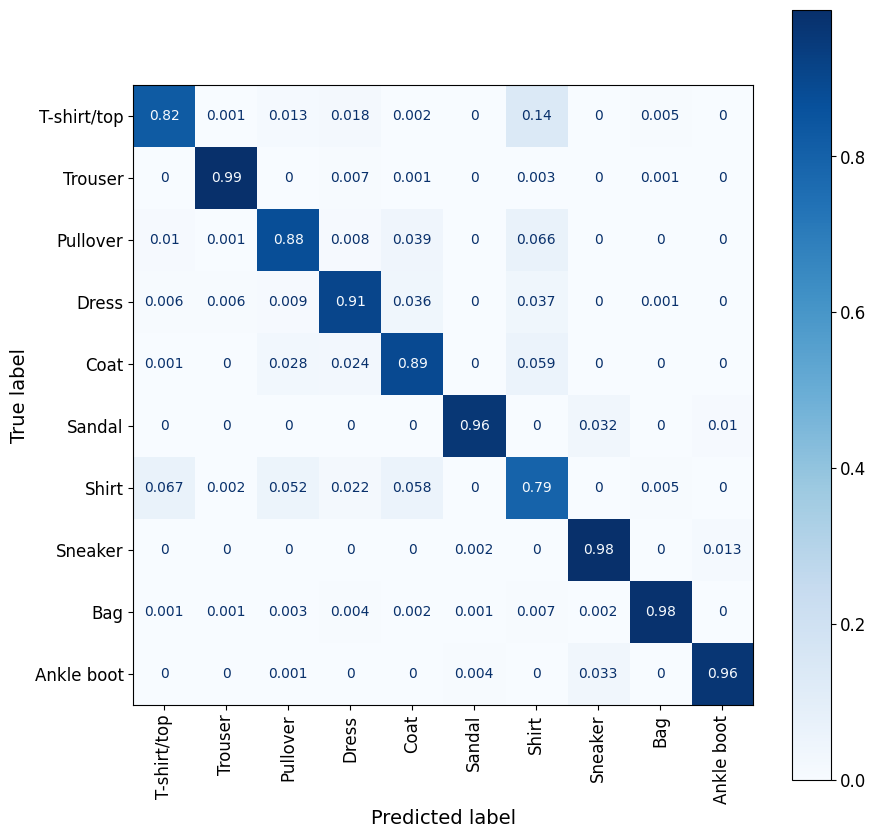

In [85]:
confnorm = confusion_matrix(y_true, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=confnorm,
                                display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

### Métricas de rendimiento
**¡AHORA TÚ!**
- Genera ahora una matriz de confusión sin normalizar.

In [86]:
conf = confusion_matrix(y_true, y_pred)
print(conf)

[[824   1  13  18   2   0 137   0   5   0]
 [  0 988   0   7   1   0   3   0   1   0]
 [ 10   1 876   8  39   0  66   0   0   0]
 [  6   6   9 905  36   0  37   0   1   0]
 [  1   0  28  24 888   0  59   0   0   0]
 [  0   0   0   0   0 958   0  32   0  10]
 [ 67   2  52  22  58   0 794   0   5   0]
 [  0   0   0   0   0   2   0 985   0  13]
 [  1   1   3   4   2   1   7   2 979   0]
 [  0   0   1   0   0   4   0  33   0 962]]


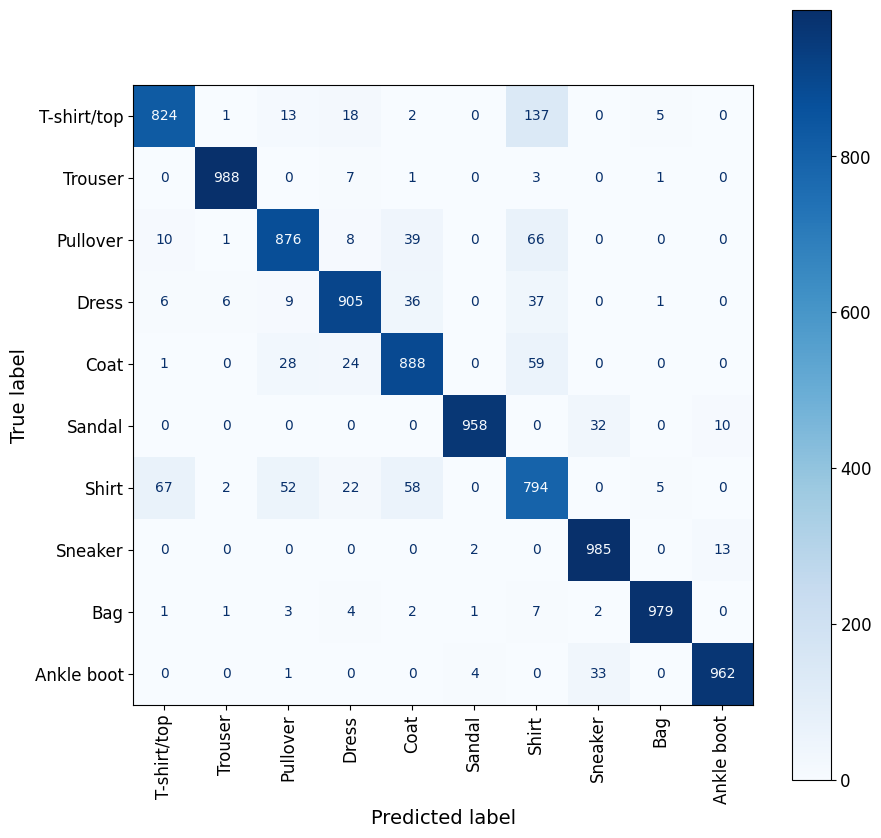

In [88]:
#SOLUTION
disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                                display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

**¡AHORA TÚ!**
- Observa cómo podemos obtener los TP,TN,FP y FN a partir de la matriz `conf`.
- Revisa el significado de estas variables y entiende cómo se han obtenido a partir de `conf`. ¿Por qué estas variables se expresan en forma de vectores en lugar de valores escalares?

In [89]:
TP = np.diag(conf)
FP = conf.sum(axis=0) - TP 
FN = conf.sum(axis=1) - TP
TN = conf.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

**¡AHORA TÚ!**
- Calcula e imprime la métrica F1-score para cada clase y su valor medio. Puedes buscar la fórmula en el tema T01.
- ¿Cuáles son las clases con las mejores/peores métricas F1-score?
- Prueba a calcular e imprimir también las métricas _Accuracy_, _Sensitivity_ y _Specificity_.

In [98]:
# SOLUTION
# F1 Score
FONE = 2*TP/(2*TP + FP + FN)

In [99]:
print("F1-score: ")
print(["{:0.2f}".format(x) for x in FONE])

F1-score: 
['0.86', '0.99', '0.88', '0.91', '0.88', '0.98', '0.76', '0.96', '0.98', '0.97']


In [100]:
print("Avg F1-score: {:0.2f}".format(np.mean(FONE)))

Avg F1-score: 0.92


In [101]:
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

In [102]:
#SOLUTION
print("Precision: ")
print(["{:0.2f}".format(x) for x in PPV])
print("Recall: ")
print(["{:0.2f}".format(x) for x in TPR])
print("Specificity: ")
print(["{:0.2f}".format(x) for x in TNR])
print("Accuracy: ")
print(["{:0.2f}".format(x) for x in ACC])


Precision: 
['0.91', '0.99', '0.89', '0.92', '0.87', '0.99', '0.72', '0.94', '0.99', '0.98']
Recall: 
['0.82', '0.99', '0.88', '0.91', '0.89', '0.96', '0.79', '0.98', '0.98', '0.96']
Specificity: 
['0.99', '1.00', '0.99', '0.99', '0.98', '1.00', '0.97', '0.99', '1.00', '1.00']
Accuracy: 
['0.97', '1.00', '0.98', '0.98', '0.97', '1.00', '0.95', '0.99', '1.00', '0.99']


# 4. Mejorando el modelo

### L1 and L2 Regularization
- Podemos incluir regularización L2 con factor 0.01 en las capas Dense o Conv2D de la siguiente manera:

<code> keras.layers.Dense(100, activation= ...,                                  
                    kernel_regularizer=keras.regularizers.l2(0.01)) </code> 
<code> keras.layers.Conv2D(32, kernel_size=...,kernel_regularizer=keras.regularizers.l2(0.01),...)
 - `l2(0.01)` para L2 con factor 0.01
 - `l1(0.1)` para L1 con factor 0.1
 - `l1_l2(0.1, 0.01)` para L1 y L2 con factores 0.1 y 0.01 respectivamente
 
**¡AHORA TÚ!**
- Crea un nuevo modelo `model5` probando a introducir regularización en las distintas capas de `model3` y entrena durante al menos 20 épocas utilizando _Early Stopping_ y algún otro _callback_ de tu elección.

In [103]:
#SOLUTION
model5 = keras.models.Sequential()
model5.add(keras.layers.Conv2D(16, kernel_size=(3, 3),kernel_regularizer=keras.regularizers.l2(0.01),
                 padding='same',use_bias=False,
                 input_shape=(28, 28, 1)))
model5.add(keras.layers.BatchNormalization())
model5.add(keras.layers.Activation("relu"))
model5.add(keras.layers.MaxPooling2D((2, 2)))
model5.add(keras.layers.Conv2D(32, kernel_size=(3, 3), kernel_regularizer=keras.regularizers.l2(0.01),
                padding='same',use_bias=False))
model5.add(keras.layers.BatchNormalization())
model5.add(keras.layers.Activation("relu"))
model5.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model5.add(keras.layers.Flatten())
model5.add(keras.layers.Dense(32,use_bias=False))
model5.add(keras.layers.BatchNormalization())
model5.add(keras.layers.Activation("relu"))
model5.add(keras.layers.Dense(10, activation='softmax'))
model5.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_18 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
activation_21 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 32)        4608      
_________________________________________________________________
batch_normalization_19 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
activation_22 (Activation)   (None, 14, 14, 32)      

In [104]:
# SOLUTION
model5.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history5 = model5.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                   callbacks=[lr_scheduler,early_stopping_cb,model_checkpoint_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 10s 185us/sample - loss: 0.6157 - acc: 0.8504 - val_loss: 0.4303 - val_acc: 0.8878
Epoch 2/20
55000/55000 [==============================] - 10s 181us/sample - loss: 0.3885 - acc: 0.8951 - val_loss: 0.3737 - val_acc: 0.8930
Epoch 3/20
55000/55000 [==============================] - 10s 182us/sample - loss: 0.3286 - acc: 0.9071 - val_loss: 0.3247 - val_acc: 0.9046
Epoch 4/20
55000/55000 [==============================] - 10s 179us/sample - loss: 0.2934 - acc: 0.9149 - val_loss: 0.3077 - val_acc: 0.9064
Epoch 5/20
55000/55000 [==============================] - 10s 182us/sample - loss: 0.2676 - acc: 0.9218 - val_loss: 0.2933 - val_acc: 0.9080
Epoch 6/20
55000/55000 [==============================] - 10s 190us/sample - loss: 0.2495 - acc: 0.9254 - val_loss: 0.2849 - val_acc: 0.9076
Epoch 7/20
55000/55000 [==============================] - 10s 183us/sample - loss: 0.2328 - acc: 0.9299 -

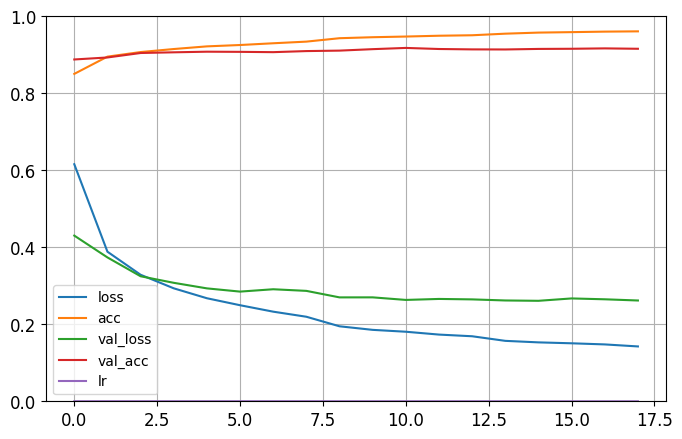

In [105]:
# SOLUTION
graph_training(history5,"model5")

### (Opcional) Aumentando la profundidad de la red

**¡AHORA TÚ!**
- Para hacer este apartado se requiere utilizar la nube de cómputo o un ordenador potente configurados con GPUs
- Lo que tenemos hasta ahora no es una red suficientemente _"deep"_. Crea un modelo `model6` aumentando el número de capas convolucionales de la red `model4` y la profundidad de la red (número de filtros de convolución).   
  - Deberías aumentar el número de channels en las capas más profundas de la red, ¿sabes contestar por qué?.
   - Observa que también puedes aumentar el número de neuronas en la capa _hidden_ de perceptrón multicapa (MLP) que hay al final de la red.
   - Controla el número de parámetros entrenables y número de capas en un tamaño manejable para el equipo que estás utilizando.
   - No utilices regularización L2 en este experimento si tu ordenador es demasiado lento.
   - Recuerda que puedes añadir _callbacks_ para variar el _learning rate_ dinámicamente.
   - Lanza el entrenamiento para un número de _epochs_ elevado (por ejemplo 50) y recuerda que puedes utilizar _early stopping_ ajustando el parámetro _patience_.
- A ver si puedes obtener un resultado cercano a `val_accuracy` en torno a 93%... ¡o mejor aún!

In [106]:
# SOLUTION
model6 = keras.models.Sequential()
model6.add(keras.layers.Conv2D(16, kernel_size=(3, 3),
                 padding='same',use_bias=False,input_shape=(28, 28, 1)))
model6.add(keras.layers.BatchNormalization())
model6.add(keras.layers.Activation('relu'))
model6.add(keras.layers.MaxPooling2D((2, 2)))
model6.add(keras.layers.Dropout(0.25)),
model6.add(keras.layers.Conv2D(32, kernel_size=(3, 3),padding='same',use_bias=False))
model6.add(keras.layers.BatchNormalization())
model6.add(keras.layers.Activation("relu"))
model6.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model6.add(keras.layers.Dropout(0.25)),
model6.add(keras.layers.Conv2D(64, kernel_size=(3, 3),padding='same',use_bias=False))
model6.add(keras.layers.BatchNormalization())
model6.add(keras.layers.Activation("relu"))
model6.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model6.add(keras.layers.Dropout(0.25)),
model6.add(keras.layers.Conv2D(128, kernel_size=(3, 3),padding='same',use_bias=False))
model6.add(keras.layers.BatchNormalization())
model6.add(keras.layers.Activation("relu"))
model6.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model6.add(keras.layers.Dropout(0.25)),
model6.add(keras.layers.Flatten())
model6.add(keras.layers.Dense(128,use_bias=False))
model6.add(keras.layers.BatchNormalization())
model6.add(keras.layers.Activation("relu"))
model6.add(keras.layers.Dense(10, activation='softmax'))
model6.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
activation_24 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 32)        4608      
_________________________________________________________________
batch_normalization_22 (Batc (None, 14, 14, 32)      

In [107]:
# SOLUTION
model6.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
history6 = model6.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid),
                   callbacks=[lr_scheduler,early_stopping_cb,model_checkpoint_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 19s 338us/sample - loss: 0.6449 - acc: 0.7629 - val_loss: 0.4298 - val_acc: 0.8392
Epoch 2/50
55000/55000 [==============================] - 18s 320us/sample - loss: 0.4463 - acc: 0.8375 - val_loss: 0.3312 - val_acc: 0.8794
Epoch 3/50
55000/55000 [==============================] - 17s 309us/sample - loss: 0.4009 - acc: 0.8539 - val_loss: 0.3020 - val_acc: 0.8866
Epoch 4/50
55000/55000 [==============================] - 18s 323us/sample - loss: 0.3668 - acc: 0.8680 - val_loss: 0.2927 - val_acc: 0.8926
Epoch 5/50
55000/55000 [==============================] - 17s 306us/sample - loss: 0.3535 - acc: 0.8725 - val_loss: 0.2961 - val_acc: 0.8928
Epoch 6/50
55000/55000 [==============================] - 17s 304us/sample - loss: 0.3365 - acc: 0.8767 - val_loss: 0.2692 - val_acc: 0.9014
Epoch 7/50
55000/55000 [==============================] - 17s 313us/sample - loss: 0.3295 - acc: 0.8801 -

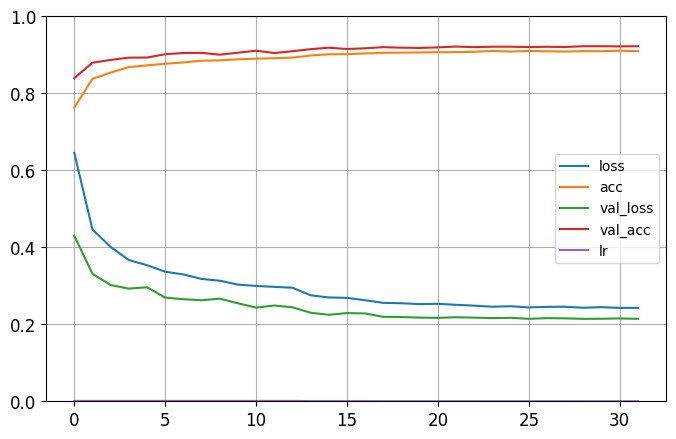

In [109]:
# SOLUTION
graph_training(history6,"model6")

## Ampliación

- Blog towardsdatascience: The 4 Convolutional Neural Network Models That Can Classify Your Fashion Images

https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d
- Fashion MNIST benchmark

https://paperswithcode.com/sota/image-classification-on-fashion-mnist